# Homework 04. Mixed Integer Programming/Simplex/Sudoku

MSCA 32013 Optimization and Simulation Methods. University of Chicago.

Group 7. Ben Ossyra, Peter Pezon. Yawen Zhang. 

## Bus Schedule Problem 

1 - The city of Chicago hired your services to create a daily schedule for the bus drivers for a given bus route. Because of changes in demand throughout the day, the number of buses needed varies. The number of buses scheduled are shown below:

| Start | End | Buses |
| ----- | ------ | ----- | 
|  12am    |	4am	 |	2	 | 
|  4am    |	8am	 |	7 | 
|  8am    |	12pm	 |	10 | 
|  12pm    |	4pm	 |	15 | 
|  4pm    |	8pm	 |	5 | 
|  8pm    |	12am	 |	2 |

A driver must be scheduled for an 8 hour shift, and the driver has to start at the beginning of one of the stipulated starting times. The shifts start at midnight, 4AM, 8AM, 12PM, 4PM, 8PM, and last for 8 hours. Note that a bus driver that starts at 8PM works until 4AM of the next day. 
<br />

Your proposed schedule must include enough bus drivers to drive the scheduled buses in each period. All scheduled buses must be in service! Your goal is to minimize the number of bus drivers hired while making sure that there are enough drivers for the scheduled buses during each interval.


Define our variables: 

* $x_{1}$ is the number of drivers that starts at 12AM.
* $x_{2}$ is the number of drivers that starts at 4AM.
* $x_{3}$ is the number of drivers that starts at 8AM.
* $x_{4}$ is the number of drivers that starts at 12PM.
* $x_{5}$ is the number of drivers that starts at 4PM.
* $x_{6}$ is the number of drivers that starts at 8PM.


Regarding constraints:

It must include enough bus drivers to drive the scheduled buses in each period:

$$ x6 + x1 \geq 2 $$
$$ x1 + x2 \geq 7 $$
$$ x2 + x3 \geq 10 $$
$$ x3 + x4 \geq 15 $$
$$ x4 + x5 \geq 5 $$
$$ x5 + x6 \geq 2 $$


The objective function is defined as:

$$ min\ \  x_{1} + x_{2} + x_{3} + x_{4} + x_{5} + x_{6} $$


In [19]:
using JuMP, GLPK

myModel = Model(GLPK.Optimizer)
@variable(myModel, x1 >= 0, Int)
@variable(myModel, x2 >= 0, Int)
@variable(myModel, x3 >= 0, Int)
@variable(myModel, x4 >= 0, Int)
@variable(myModel, x5 >= 0, Int)
@variable(myModel, x6 >= 0, Int)
@constraint(myModel, x6   + x1 >=2)
@constraint(myModel, x1   + x2 >=7)
@constraint(myModel, x2   + x3 >=10)
@constraint(myModel, x3   + x4 >=15)
@constraint(myModel, x4   + x5 >=5)
@constraint(myModel, x5   + x6 >=2)

@objective(myModel, Min, x1+x2+x3+x4+x5+x6)
print(myModel)



In [2]:
@time begin
    status = optimize!(myModel)
end
println("Objective value: ", JuMP.objective_value(myModel))
println("x1 = ", JuMP.value(x1))
println("x2 = ", JuMP.value(x2))
println("x3 = ", JuMP.value(x3))
println("x4 = ", JuMP.value(x4))
println("x5 = ", JuMP.value(x5))
println("x6 = ", JuMP.value(x6))

  1.247538 seconds (5.98 M allocations: 438.563 MiB, 5.83% gc time, 99.90% compilation time)
Objective value: 24.0
x1 = 2.0
x2 = 5.0
x3 = 12.0
x4 = 3.0
x5 = 2.0
x6 = 0.0


The optimal number of drivers is 24.  
2 drivers are scheduled to start at 12AM.  
5 drivers are scheduled to start at 4AM.  
12 drivers are scheduled to start at 8AM.  
3 drivers are scheduled to start at 12PM.  
2 drivers are scheduled to start at 4PM.  
And 0 drivers will start at 8PM.

## Simplex Problem 1 - Consider the following LP problem:

\begin{equation}
\max_{x}\ \ {-3x_1 + 4x_2}\\
\mathrm{s.t.}
\left\{
\begin{aligned}
-x_1 + x_2 \leq 0 \\
-x_1 + 2x_2 \leq 2 \\
x_1 \geq 1 \\
x_2 \leq 3 \\
x_1, x_2 \geq 0 \\
\end{aligned}\right.
\end{equation}

### A. Plot all linear constraints and the objective function at the optimal level

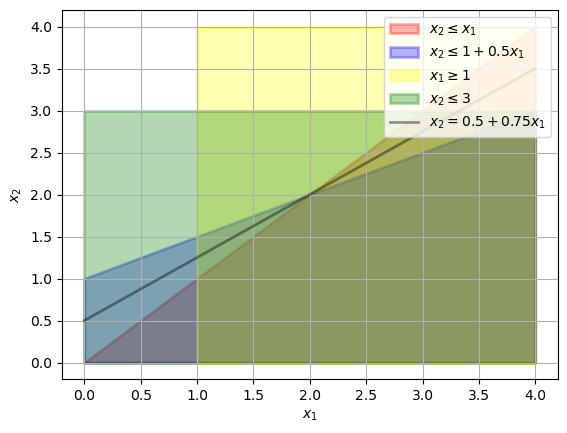

In [3]:
using PyPlot

x1 = collect(0:0.1:4)
x2 = collect(0:0.1:4)

x2a = ifelse.(x1 .>= 0, x1, NaN);
x2b = ifelse.(1 .+ 0.5 .* x1 .>=0, 1 .+ 0.5 .* x1, NaN)
x2c = 0.5 .+ 0.75 .* x1


fig, ax = subplots()

ax.fill_between(x1,x2a,color="red",linewidth=2,label=L"x_{2} \leq x_{1}",alpha=0.3)
ax.fill_between(x1,x2b,color="blue", linewidth=2,label=L"x_{2} \leq 1 + 0.5x_{1}",alpha=0.3)
ax.fill_betweenx(x2,1,4,color="yellow" ,linewidth=2,label=L"x_{1} \geq 1",alpha=0.3)
ax.fill_between(x1,3,color="green",linewidth=2,label=L"x_{2} \leq 3",alpha=0.3)

ax.plot(x1,x2c,color="black",linewidth=2,label=L"x_{2} = 0.5 + 0.75x_{1}",alpha=0.4)

ax.set_xlabel(L"x_{1}");
ax.set_ylabel(L"x_{2}");
ax.legend(loc="upper right");
ax.grid("on");


### B. Produce a table with all possible basic solutions and their respective objective function values. Determine the solution.

In [4]:
using JuMP, GLPK, LinearAlgebra

model1 = Model(GLPK.Optimizer)

c = [-3; 4; 0; 0; 0; 0]
A = [-1 1 1 0  0 0;
     -1 2 0 1  0 0;
      1 0 0 0 -1 0; 
      0 1 0 0  0 1]
b = [0; 2; 1; 3]

m, n = size(A)

@variable(model1, x[1:n] >= 0)
@objective(model1, Max, sum(c[i]*x[i] for i in 1:n))

@constraint(model1, constraint[j in 1:m], sum( A[j,i]*x[i] for i in 1:n) == b[j])

print(model1)

In [5]:
println("The rank of the matrix A: ", rank(A))
println("The number of linear restrictions: ", m)
println("The number of variables: ",n)
println("Number of basic solutions n!/m!(n-m)!: ",factorial(n)/(factorial(m)*factorial(n-m)))

The rank of the matrix A: 4
The number of linear restrictions: 4
The number of variables: 6
Number of basic solutions n!/m!(n-m)!: 15.0


In [6]:
using DataFrames, DataFramesMeta, Combinatorics

In [7]:
combs = collect(combinations(1:n, m))
resual = DataFrame(comb_1=NaN,comb_2=NaN,comb_3=NaN,comb_4=NaN,x_B_1=NaN,x_B_2=NaN,x_B_3=NaN,x_B_4=NaN,z=NaN)

for i in 1:length(combs)
    comb = combs[i,]
    B = A[:, comb]
    c_B = c[comb]
    
    if det(B) == 0
        z = -Inf
        push!(resual, ([comb[1],comb[2],comb[3],comb[4],NaN,NaN,NaN,NaN,z]))
    else
        x_B = inv(B)*b

        if minimum(x_B)>0
            z = dot(c_B, x_B)
        else 
            z = -Inf
        end
        if i==1
            resual = DataFrame(comb_1=comb[1],comb_2=comb[2],comb_3=comb[3],comb_4=comb[4],
                x_B_1=x_B[1],x_B_2=x_B[2],x_B_3=x_B[3],x_B_4=x_B[4],z=z)
        else
            push!(resual, ([comb[1],comb[2],comb[3],comb[4],x_B[1],x_B[2],x_B[3],x_B[4],z]))
        end
    end
end
sort!(resual,:z,rev=true)

Row,comb_1,comb_2,comb_3,comb_4,x_B_1,x_B_2,x_B_3,x_B_4,z
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,1,2,5,6,2.0,2.0,1.0,1.0,2.0
2,1,2,4,6,1.0,1.0,1.0,2.0,1.0
3,1,2,3,5,4.0,3.0,1.0,3.0,0.0
4,1,3,4,6,1.0,1.0,3.0,3.0,-3.0
5,1,2,3,4,1.0,3.0,-2.0,-3.0,-Inf
6,1,2,3,6,1.0,1.5,-0.5,1.5,-Inf
7,1,2,4,5,3.0,3.0,-1.0,2.0,-Inf
8,1,3,4,5,NaN,NaN,NaN,NaN,-Inf
9,1,3,5,6,-2.0,-2.0,-3.0,3.0,-Inf


In the optimal solution in the table above x1=2, x2=2, x3=1, x4=1 and the objective value is 2

### C. Solve the problem using the step by step simplex method discussed in the lecture. Verify that the solution is the same as in item B.

#### Notes: 
We tried many different ways to solve the problem, but were having trouble getting the code to work well. Below are our two attempts:

#### Attempt 1 - Simplex

In [8]:
using JuMP, GLPK, LinearAlgebra

model2 = Model(GLPK.Optimizer)

c = [-3; 4; 0; 0; 0; 0]
A = [-1 1 1 0  0 0;
     -1 2 0 1  0 0;
      1 0 0 0 -1 0; 
      0 1 0 0  0 1]
b = [0; 2; 1; 3]

m, n = size(A)

@variable(model2, x[1:n] >= 0)
@objective(model2, Max, sum(c[i]*x[i] for i in 1:n))

@constraint(model2, constraint[j in 1:m], sum( A[j,i]*x[i] for i in 1:n) == b[j])

println("The optimization problem to be solved is:")
print(model2)
println(" ")
println("The rank of the matrix A: ",rank(A))
println("The number of linear restrictions: ", m)
println("The number of variables: ",n)
println("Number of basic solutions n!/m!(n-m)!: ",factorial(n)/(factorial(m)*factorial(n-m)))

The optimization problem to be solved is:


 
The rank of the matrix A: 4
The number of linear restrictions: 4
The number of variables: 6
Number of basic solutions n!/m!(n-m)!: 15.0


In [9]:
# Step 1 - initial assignment of basic and non-basic variables

## indices of matrix A
### iB: basic variables index
### iK: non-basic variables index

iB = collect(3:6)
iK = collect(1:2)

## construct matrix [B K]

B = A[:, iB];
K = A[:,iK];

println("List of indices for the basic variables:\n",iB)
println("List of indices for the non-basic variables:\n",iK)

List of indices for the basic variables:
[3, 4, 5, 6]
List of indices for the non-basic variables:
[1, 2]


In [10]:
## compute xB, xK, and objective function z
cB = c[iB];
cK = c[iK];

xB = inv(B)*b;
xK = [0;0];

println("The updated B matrix is:\n",B)
println("The updated K matrix is:\n",K)
println("The updated solution for the basic variable, xB is:\n",xB)
println("The updated solution for the non-basic variable, xK is:\n",xK)
println("The updated coefficient vector for the objective function, cB, is: \n",cB)
println("The updated coefficient vector for the objective function, cK, is: \n",cK)
println("The updated objective function value, z, is:\n",[cB; cK]'*[xB;xK])

The updated B matrix is:
[1 0 0 0; 0 1 0 0; 0 0 -1 0; 0 0 0 1]
The updated K matrix is:
[-1 1; -1 2; 1 0; 0 1]
The updated solution for the basic variable, xB is:
[0.0, 2.0, -1.0, 3.0]
The updated solution for the non-basic variable, xK is:
[0, 0]
The updated coefficient vector for the objective function, cB, is: 
[0, 0, 0, 0]
The updated coefficient vector for the objective function, cK, is: 
[-3, 4]
The updated objective function value, z, is:
0.0


In [11]:
cc = (cK'-cB'*inv(B)*K);
indK2B = iK[argmin(cc)[2]];
println(cc)
println("The entering variable has index of ",indK2B)

[-3.0 4.0]
The entering variable has index of 1


In [12]:
## ratio test
y = inv(B)*A;
a = inv(B)*b./y[:,indK2B];
a = ifelse.(a.<0,Inf,a)
indB2K = iB[argmin(a)];
println(a)
println("The exiting variable has index of ",indB2K)

[-0.0, Inf, 1.0, Inf]
The exiting variable has index of 3


In [13]:
iB[argmin(ifelse.(a.<0,Inf,a))] = indK2B;
iK[argmin(cc)[2]] = indB2K;
println("List of indices for the basic variables:\n",iB)
println("List of indices for the non-basic variables:\n",iK)

B = A[:,iB];
K = A[:,iK];

cB = c[iB];
cK = c[iK];

println("The updated B matrix is:\n",B)
println("The updated K matrix is:\n",K)
println("The updated coefficient vector for the objective function, cB, is:\n",cB)
println("The updated coefficient vector for the objective function, cK, is:\n",cK)

xB = inv(B)*b;
xK = [0;0];

println("The updated solution for the basic variable, xB is:\n",xB)
println("The updated solution for the non-basic variable, xK is:\n",xK)
println("The updated objective function value, z, is:\n",[cB; cK]'*[xB;xK])

List of indices for the basic variables:
[1, 4, 5, 6]
List of indices for the non-basic variables:
[3, 2]
The updated B matrix is:
[-1 0 0 0; -1 1 0 0; 1 0 -1 0; 0 0 0 1]
The updated K matrix is:
[1 1; 0 2; 0 0; 0 1]
The updated coefficient vector for the objective function, cB, is:
[-3, 0, 0, 0]
The updated coefficient vector for the objective function, cK, is:
[0, 4]
The updated solution for the basic variable, xB is:
[0.0, 2.0, -1.0, 3.0]
The updated solution for the non-basic variable, xK is:
[0, 0]
The updated objective function value, z, is:
0.0


In [14]:
cc = (cK'.-cB'*inv(B)*K);
indK2B = iK[argmin(cc)[2]];

println(cc)
println("The entering variable has index of ",indK2B)

y = inv(B)*A;
a = inv(B)*b./y[:,indK2B];
indB2K = iB[argmin(ifelse.(a.<0,Inf,a))];

println(a)
println("The exiting variable has index of ",indB2K)

[-3.0 1.0]
The entering variable has index of 3
[-0.0, -2.0, 1.0, Inf]
The exiting variable has index of 1


In [15]:
# Update indices
iB[argmin(ifelse.(a.<0,Inf,a))] = indK2B;
iK[argmin(cc)[2]] = indB2K;
println("List of indices for the basic variables: ",iB)
println("List of indices for the non-basic variables: ",iK)

B = A[:,iB];
K = A[:,iK];

cB = c[iB];
cK = c[iK];

println("The updated B matrix is: \n",B)
println("The updated K matrix is: \n",K)
println("The updated coefficient vector for the objective function, cB, is: \n",cB)
println("The updated coefficient vector for the objective function, cK, is: \n",cK)

xB = inv(B)*b;
xK = [0;0];

println("xB equals: ",xB)
println("xK equals: ",xK)
println("The objective function value, z, is: ",[cB; cK]'*[xB;xK])

List of indices for the basic variables: [3, 4, 5, 6]
List of indices for the non-basic variables: [1, 2]
The updated B matrix is: 
[1 0 0 0; 0 1 0 0; 0 0 -1 0; 0 0 0 1]
The updated K matrix is: 
[-1 1; -1 2; 1 0; 0 1]
The updated coefficient vector for the objective function, cB, is: 
[0, 0, 0, 0]
The updated coefficient vector for the objective function, cK, is: 
[-3, 4]
xB equals: [0.0, 2.0, -1.0, 3.0]
xK equals: [0, 0]
The objective function value, z, is: 0.0


#### Attempt 2 - Simplex

In [16]:
# Create a module to solve it 
module SimplexMethod
    using LinearAlgebra, Combinatorics, Printf
    export simplex_method

    # There are five fields in this data type. 
    mutable struct SimplexTableau
    z_c     ::Array{Float64} # z_j - c_j
    Y       ::Array{Float64} # inv(B) * A
    x_B     ::Array{Float64} # inv(B) * b
    obj     ::Float64        # c_B * x_B
    b_idx   ::Array{Int64}   # indices for basic variables x_B
    end
  
    # we define some functions 
    function is_nonnegative(x::Vector)
        return length( x[ x .< 0] ) == 0
    end

    function is_nonpositive(z::Array)
        return length( z[ z .> 0] ) == 0
    end

    function initial_BFS(A, b)
        m, n = size(A)

        comb = collect(combinations(1:n, m))
        for i in length(comb):-1:1
          b_idx = comb[i]
          B = A[:, b_idx]
          x_B = inv(B) * b
          if is_nonnegative(x_B)
            return b_idx, x_B, B
          end
        end

        error("Infeasible")
      end

      function print_tableau(t::SimplexTableau)
        m, n = size(t.Y)

        hline0 = repeat("-", 6)
        hline1 = repeat("-", 7*n)
        hline2 = repeat("-", 7)
        hline = join([hline0, "+", hline1, "+", hline2])

        println(hline)

        @printf("%6s|", "")
        for j in 1:length(t.z_c)
          @printf("%6.2f ", t.z_c[j])
        end
        @printf("| %6.2f\n", t.obj)

        println(hline)

        for i in 1:m
          @printf("x[%2d] |", t.b_idx[i])
          for j in 1:n
            @printf("%6.2f ", t.Y[i,j])
          end
          @printf("| %6.2f\n", t.x_B[i])
        end

        println(hline)
      end

      function pivoting!(t::SimplexTableau)
        m, n = size(t.Y)

        entering, exiting = pivot_point(t)
        println("Pivoting: entering = x_$entering, exiting = x_$(t.b_idx[exiting])")

    
    
        # Pivoting: exiting-row, entering-column
        # updating exiting-row
        coef = t.Y[exiting, entering]
        t.Y[exiting, :] /= coef
        t.x_B[exiting] /= coef

        # updating other rows of Y
        for i in setdiff(1:m, exiting)
          coef = t.Y[i, entering]
          t.Y[i, :] -= coef * t.Y[exiting, :]
          t.x_B[i] -= coef * t.x_B[exiting]
        end

        # updating the row for the reduced costs
        coef = t.z_c[entering]
        t.z_c -= coef * t.Y[exiting, :]'
        t.obj -= coef * t.x_B[exiting]
    
        # Updating b_idx
        t.b_idx[ findfirst(t.b_idx .== t.b_idx[exiting]) ] = entering
      end
    
      function pivot_point(t::SimplexTableau)
        # Finding the entering variable index
        entering = findfirst( t.z_c .> 0)[2]
        if entering == 0
          error("Optimal")
        end

        # min ratio test / finding the exiting variable index
        pos_idx = findall( t.Y[:, entering] .> 0 )
        if length(pos_idx) == 0
          error("Unbounded")
        end
        exiting = pos_idx[ argmin( t.x_B[pos_idx] ./ t.Y[pos_idx, entering] ) ]

        return entering, exiting
      end

      function initialize(c, A, b)
        c = Array{Float64}(c)
        A = Array{Float64}(A)
        b = Array{Float64}(b)

        m, n = size(A)

        # Finding an initial BFS
        b_idx, x_B, B = initial_BFS(A,b)

        Y = inv(B) * A
        c_B = c[b_idx]
        obj = dot(c_B, x_B)

        # z_c is a row vector
        z_c = zeros(1,n)
        n_idx = setdiff(1:n, b_idx)
        z_c[n_idx] = c_B' * inv(B) * A[:,n_idx] - c[n_idx]'

        return SimplexTableau(z_c, Y, x_B, obj, b_idx)
      end

      function is_optimal(t::SimplexTableau)
        return is_nonpositive(t.z_c)
      end

      function simplex_method(c, A, b)
        tableau = initialize(c, A, b)
        print_tableau(tableau)

        while !is_optimal(tableau)
          pivoting!(tableau)
          print_tableau(tableau)
        end

        opt_x = zeros(length(c))
        opt_x[tableau.b_idx] = tableau.x_B

        return opt_x, tableau.obj
      end

    end

Main.SimplexMethod

In [17]:
c = [3; -4; 0; 0; 0; 0]
A = [-1 1 1 0 0 0;
     -1 2 0 1 0 0;
     -1 0 0 0 1 0
     0  1 0 0 0 1]
b = [0; 2; 1; 3]

using Main.SimplexMethod
simplex_method(c, A, b)



------+------------------------------------------+-------
      | -3.00   4.00   0.00   0.00   0.00   0.00 |   0.00
------+------------------------------------------+-------
x[ 3] | -1.00   1.00   1.00   0.00   0.00   0.00 |   0.00
x[ 4] | -1.00   2.00   0.00   1.00   0.00   0.00 |   2.00
x[ 5] | -1.00   0.00   0.00   0.00   1.00   0.00 |   1.00
x[ 6] |  0.00   1.00   0.00   0.00   0.00   1.00 |   3.00
------+------------------------------------------+-------
Pivoting: entering = x_2, exiting = x_3
------+------------------------------------------+-------
      |  1.00   0.00  -4.00   0.00   0.00   0.00 |   0.00
------+------------------------------------------+-------
x[ 2] | -1.00   1.00   1.00   0.00   0.00   0.00 |   0.00
x[ 4] |  1.00   0.00  -2.00   1.00   0.00   0.00 |   2.00
x[ 5] | -1.00   0.00   0.00   0.00   1.00   0.00 |   1.00
x[ 6] |  1.00   0.00  -1.00   0.00   0.00   1.00 |   3.00
------+------------------------------------------+-------
Pivoting: entering = x_1, exitin

([2.0, 2.0, 0.0, 0.0, 3.0, 1.0], -2.0)

In [18]:
c = [-3; 4; 0; 0; 0; 0]
A = [-1 1 1 0  0 0;
     -1 2 0 1  0 0;
      1 0 0 0 -1 0; 
      0 1 0 0  0 1]
b = [0; 2; 1; 3]
using Main.SimplexMethod
simplex_method(c, A, b)
A = [-1 1 1 0  0 0;
     -1 2 0 1  0 0;
      1 0 0 0 -1 0; 
      0 1 0 0  0 1]

LoadError: SingularException(4)

### D. Solve the problem using the LP solver from Julia. Verify that the solution coincide with the solution in items B and C.

In [ ]:
m = Model(GLPK.Optimizer)

@variable(m, x1 >= 0)
@variable(m, x2 >= 0)

@constraint(m, constraint_1, -x1 + x2 <= 0)
@constraint(m, constraint_2, -x1 + 2x2 <= 2)
@constraint(m, constraint_3, x1 >= 1)
@constraint(m, constraint_4, x2 <=3)

@objective(m, Max, -3x1 + 4x2)

print(m)

In [ ]:
JuMP.optimize!(m)


println("Objective value: ", JuMP.objective_value(m))


println("x1 = ", JuMP.value(x1))  
println("x2 = ", JuMP.value(x2)) 

Objective value: 2.0
x1 = 2.0
x2 = 2.0


This solution does match what we discovered by looking at the table of all possible basic solutions and also matches the graphical interpretation. Despite our best efforts, we had trouble getting the simplex step by step code to work.

## Q3. Sudoku Problem 

Solve a Sudoku puzzle using integer programming.

In Sudoku, a 9 x grid is presented with some grids filled in, and others left blank.

In [ ]:
using CSV
using DataFrames

T = CSV.read("/Users/benjaminossyra/Desktop/Optimization/sudoku.csv", DataFrame; delim = ',', header=false)
T = Matrix(T)

9×9 Matrix{Int64}:
 3  1  0  0  5  8  0  0  4
 0  0  9  3  2  0  0  0  0
 0  2  5  1  0  4  0  9  0
 0  0  0  0  0  0  3  8  9
 0  0  8  0  0  0  5  0  0
 5  4  6  0  0  0  0  0  0
 0  8  0  2  0  3  6  5  0
 0  0  0  0  7  1  4  0  0
 7  0  0  4  8  0  0  2  1

### Variables

We encode our digit into a vector of size 9, of which the components take on the value of 0 or 1. 

Let $k$ represent an index for the digit value.

$$
Let k = 1 = $[1 0 0 0 0 0 0 0 0 ]
Let k = 2 = $[0 1 0 0 0 0 0 0 0 ]
...
$$

We need to represent a number on a sudoki grid. We will repesent digit at a position as a 9x9x9 matrix, indexed by row, cell, and digit, valued at 0 or 1 for whther there is a number at that position. There are a 729 variables because 9x9x9.

$ x[i,j,k] = 1 $

Example:

$ x[7,4,6] = 1 $ represents number 6 in row 7 column 4.

### Objective

We have to make a decision on whether to put 6 on that position. There is only one unique solution in Sudoku, so we only need to identify the solution rather than maximize or minimize an objective function. Objective function is determining existence. 

### Constraints

There are several constraints:
* Digits across rows must be unique.
* Digits across columns must be unique.
* Digits within 9 3x3 grids must be unique.
* The initial value of the puzzle.
* Only one digit can exist at a grid position at a time.

To ensure only one digit exists  to make sure digit is used only once?

$ x[1,1,1] + x[1,2,1] + ... + x[1,9,1] = 1 $
$ x[1,1,2] + x[1,2,2] + ... + x[1,9,2] = 1 $

This works bc value can either be 1 or 0, and if digit can only appear once, then the sum is 1.

Repeat for columns:

$ x[1,1,1] + x[2,1,1] + ... + x[9,1,1] = 1 $
$ x[1,1,2] + x[2,1,2] + ... + x[9,1,2] = 1 $

Guarantees that #1 appears only once in the column; that #2 appears only once in the column. Repeat similar process for making sure only digit is selected at a grid position. 

Create solution framework - define constraints, variables, objective. Then have Julia solve.

In [ ]:
using JuMP, GLPK

m = Model(GLPK.Optimizer)

#Define Variables

@variable(m, x[1:9, 1:9, 1:9], Bin)

#Define Constraints
for i =1:9
    for j = 1:9
        @constraint(m, sum(x[i,j,:])==1)
    end    
end

for i =1:9
    for k = 1:9
        @constraint(m, sum(x[i,:,k])==1)
    end    
end

for j =1:9
    for k = 1:9
        @constraint(m, sum(x[:,j,k])==1)
    end    
end

#each subgrid contains the digits 1 to 9
for i = 1:3:7
    for j = 1:3:7
        for k =1:9
            @constraint(m, sum(x[i:i + 2, j:j + 2, k]) == 1)
        end
    end
end

for i =1:9
    for j = 1:9
        if T[i,j]!=0
            @constraint(m, x[i,j,T[i,j]]==1)
        end
    end
end


#Declare Objective

@objective(m, Min, sum(x[i,j,k] for i=1:9, j=1:9, k=1:9))

JuMP.optimize!(m)


Create solution matrix

In [ ]:
solMat = JuMP.value.(x)

optsol = zeros(9,9)

for i = 1:9
    for j=1:9
        optsol[i,j] = argmax(solMat[i,j,:])
    end
end
optsol

9×9 Matrix{Float64}:
 3.0  1.0  7.0  9.0  5.0  8.0  2.0  6.0  4.0
 4.0  6.0  9.0  3.0  2.0  7.0  8.0  1.0  5.0
 8.0  2.0  5.0  1.0  6.0  4.0  7.0  9.0  3.0
 2.0  7.0  1.0  6.0  4.0  5.0  3.0  8.0  9.0
 9.0  3.0  8.0  7.0  1.0  2.0  5.0  4.0  6.0
 5.0  4.0  6.0  8.0  3.0  9.0  1.0  7.0  2.0
 1.0  8.0  4.0  2.0  9.0  3.0  6.0  5.0  7.0
 6.0  9.0  2.0  5.0  7.0  1.0  4.0  3.0  8.0
 7.0  5.0  3.0  4.0  8.0  6.0  9.0  2.0  1.0

Solution matrix is above